In [1]:
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sb
import warnings
import pymc3 as pm
%matplotlib inline

In [4]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

In [5]:
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2],
                                                       [1,1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

In [13]:
X.shape,y.shape

((2, 100), (100,))

In [11]:
def scatter_plot(x, y):
    pl.figure(figsize=(10,10))
    for idx, x_i in enumerate(x):
        pl.subplot(2,2,idx+1)
        pl.scatter(x_i, y)
        pl.xlabel('$x_{}$'.format(idx), fontsize=16)
        pl.ylabel('$y$'.format(idx), rotation=0, fontsize=16)
    pl.subplot(2,2,idx+2)
    pl.scatter(x[0], x[1])
    pl.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    pl.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

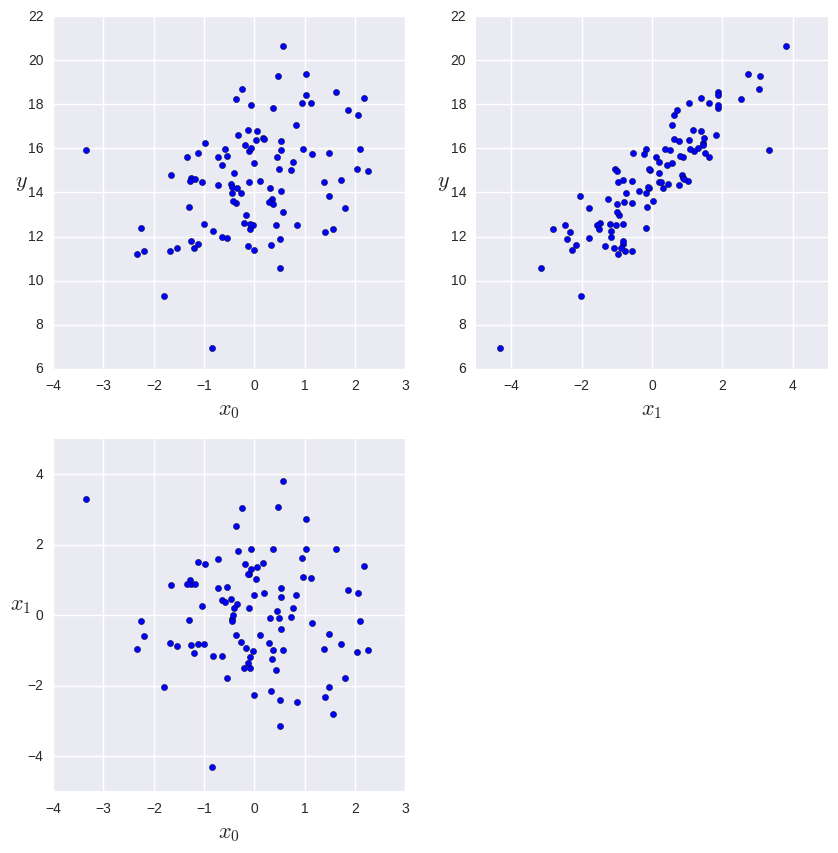

In [12]:
scatter_plot(X_centered, y)

Optimization terminated successfully.
         Current function value: 74.986175
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:08<00:00, 602.37it/s] 


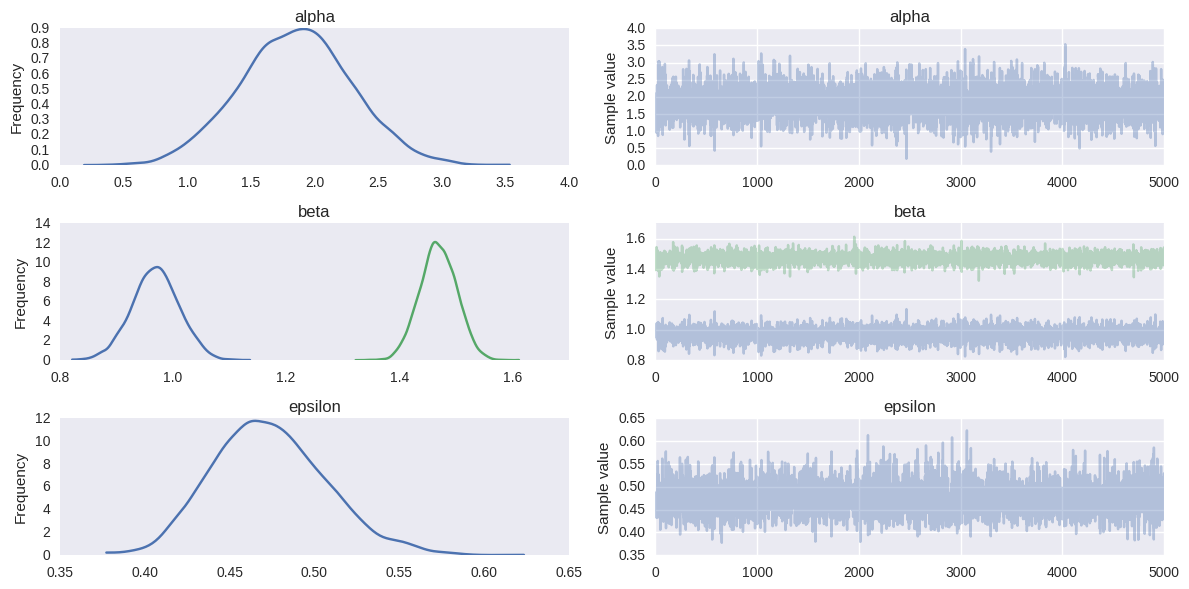

In [14]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha_tmp + pm.math.dot(beta, X_centered)
    alpha = pm.Deterministic('alpha',
                             alpha_tmp - pm.math.dot(beta, X_mean))
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)
    varnames = ['alpha', 'beta', 'epsilon']
    pm.traceplot(trace_mlr, varnames)

In [15]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.849826,0.437250,0.006066,0.985935,2.683693
beta__0,0.969078,0.042108,0.000598,0.889904,1.054053
beta__1,1.469107,0.032706,0.000493,1.405068,1.531048
epsilon,0.473294,0.033594,0.000501,0.405187,0.535546
